# Random forest classifier for NMD prediction

In [1]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

#preprocessing
from sklearn import preprocessing

In [2]:
negative_df = pd.read_csv('random_balanced_negative_set_state_100_insign_no_NMD_pub.csv', index_col = 0)
positive_df = pd.read_csv('long_read_sleuth_dKD_up_filtered_features.csv', index_col = 0)

In [3]:
#Label
negative_df['NMD_sensitivity'] = 0
positive_df['NMD_sensitivity'] = 1

In [4]:
NMD_features_df =pd.concat([negative_df, positive_df], axis=0, join='outer')
NMD_features_df.columns
NMD_features_df.dropna(inplace=True)

In [5]:
X = NMD_features_df.drop(['name_tar', 'start_ORF', 'end_ORF', 'GC_perc_30_bp_round_stop','UPF1_motifs_in3prime_total', \
                          'ORF_id', 'NMD_sensitivity'], axis=1)
y = NMD_features_df['NMD_sensitivity']

#normlaize X
X=(X-X.mean())/X.std()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
print(sum(y_test))
print(len(y_test))

676
1309


In [7]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [8]:
y_pred = rf.predict(X_test)

In [9]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6990068754774638


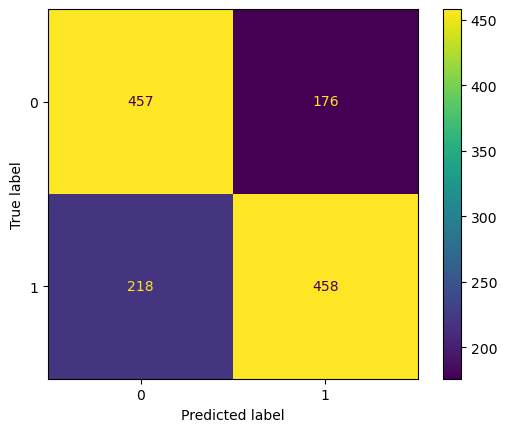

In [10]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [11]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

perm_importances = result.importances_mean
perm_std = result.importances_std
sorted_idx = perm_importances.argsort()
feature_names = X_test.columns

pd.DataFrame({'Importance': perm_importances, 'Std': perm_std}, index=feature_names[sorted_idx]).sort_values('Importance',ascending=True)

,Importance,Std
3_UTR_length,-0.003056,0.001449
GC_perc_up_15_bp_stop,-0.002903,0.002044
GC_perc_down_15_bp_stop,-0.002521,0.001567
nr_exons_in_3prime,-0.002215,0.002427
distance_stop_EJC,-0.002139,0.003396
nr_exons_in_transcript,-0.001910,0.002585
5_UTR_length,-0.001451,0.004246
stop_TAA,-0.000458,0.004599
t_length,-0.000458,0.001497
exon_with_stop_length,-0.000306,0.003521


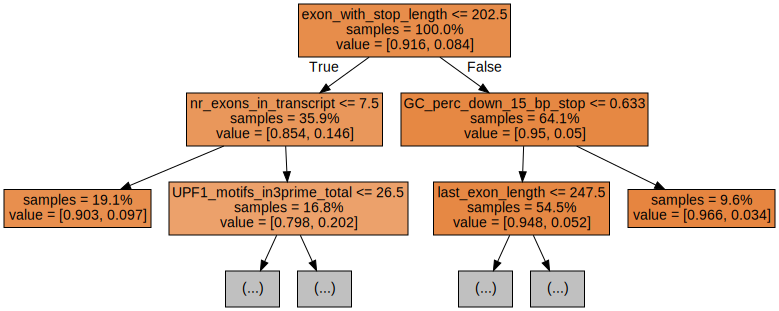

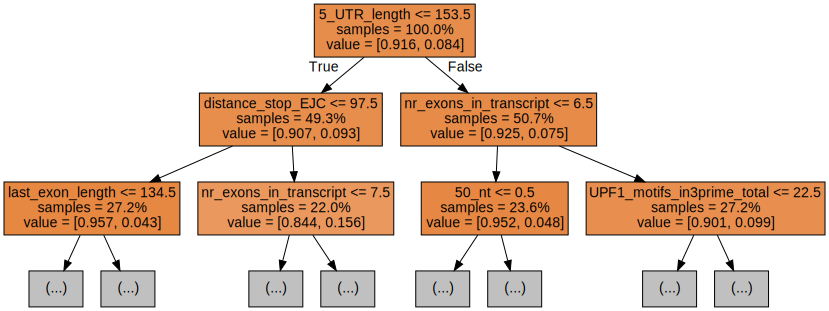

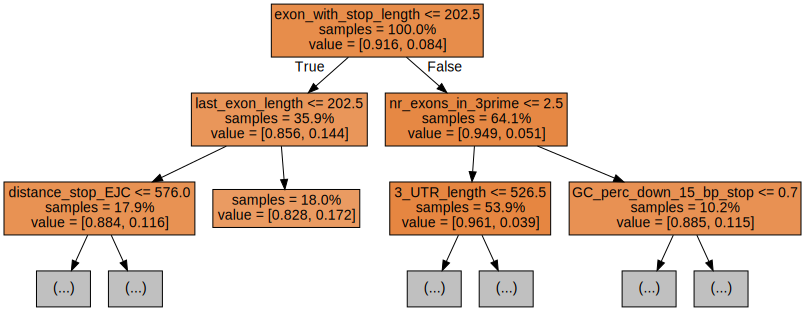

In [27]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [16]:
X_test.loc[y_test.index, "50_nt"]

MSTRG.11025.2      0.923329
ENST00000706246    0.923329
ENST00000393708   -1.082872
ENST00000498104    0.923329
ENST00000284719   -1.082872
                     ...   
ENST00000674862   -1.082872
ENST00000539904    0.923329
ENST00000591650   -1.082872
ENST00000580287    0.923329
MSTRG.26484.1      0.923329
Name: 50_nt, Length: 1313, dtype: float64

In [ ]:
#Baseline: better than 50nt rule alone
y_pred_50 = X_test.loc[y_test.index, "50_nt"]
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# Hyperparameter tuning

## Randomized search


In [12]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20), 
              'min_samples_split': randint(2,20),
              'max_features': ['sqrt', 'log2']}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=70, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=70,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17cc710d0>,
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17cc60520>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17cb58e50>})

In [13]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 17, 'max_features': 'log2', 'min_samples_split': 6, 'n_estimators': 379}


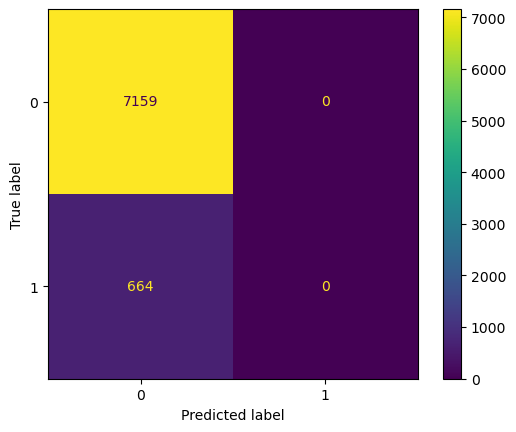

In [14]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [15]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9151220759299501


## Grid Search

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
param_values = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 100, 150, 200, 250, 300, 400, 500, 600, 800, 1000],
              'max_depth': [2,4,6,8,10, 15, 20], 
              'min_samples_split': [2,4,6,8,10, 15, 20],
              'max_features': ['sqrt']}

In [18]:
# Create a random forest classifier
rf = RandomForestClassifier()

clf = GridSearchCV(rf, param_values)
clf.fit(X_train, y_train)
GridSearchCV(estimator=rf,
             param_grid=param_values)
sorted(clf.cv_results_.keys())

KeyboardInterrupt: 